#### 작업 노트북 
- feature 정리 
- 데이터 전처리
- 모델링
- 학습 및 추론
- 제품별 추천 결과 테이블

In [19]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
%pip install sqlalchemy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
%pip install pymysql

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
%pip install konlpy

In [ ]:
%pip install matplotlib

In [196]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   --- ------------------------------------ 1.8/24.0 MB 10.1 MB/s eta 0:00:03
   ------ --------------------------------- 3.7/24.0 MB 9.5 MB/s eta 0:00:03
   ------- -------------------------------- 4.7/24.0 MB 8.1 MB/s eta 0:00:03
   ---------- ----------------------------- 6.3/24.0 MB 7.9 MB/s eta 0:00:03
   ----------- ---------------------------- 7.1/24.0 MB 7.2 MB/s eta 0:00:03
   -------------- ------------------------- 8.9/24.0 MB 7.3 MB/s eta 0:00:03
   ----------------- ---------------------- 10.7/24.0 MB 7.3 MB/s eta 0:00:02
   ------------------- -------------------- 11.8/24.0 MB 7.0 MB/s eta 0:00:02
   ---------------------- ----------------- 13.4/24.0 MB 7.0 MB/s eta 0:00:02
   ------------------------ --------------- 14.7/24.0 MB 7.3 MB/s eta 0:00:02
   --------------------------- ------------ 16.3/24.0 MB 7.0 MB/s eta 0:00:02

In [212]:
%pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
import matplotlib.pyplot as plt

from utils.preprocessing import *

warnings.filterwarnings("ignore")

#### Configuration
- 추천 서비스 생성을 위해서 필요한 설정값들을 세팅합니다.

In [2]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

#### Data Import
- 사용할 데이터를 mysql에서 가져옵니다. 

In [90]:
query_service.query_to_pandas_df('Show tables')

,Tables_in_bakery
0,board_preference_statistic
1,board_statistic
2,food_survey
3,image
4,member
5,member_preference
6,notice
7,preference
8,product
9,product_board


In [91]:
PRODUCT_BOARD_SQL = """
SELECT id
, store_id
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)

In [92]:
PRODUCT_SQL = """
SELECT id
, product_board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)

In [93]:
REVIEW_SQL = """
SELECT board_id
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')

In [94]:
BOARD_STAT_SQL = """
SELECT board_id
, board_review_grade
, board_view_count
, board_review_count
, board_wish_count 
FROM board_statistic
"""
board_stat = query_service.query_to_pandas_df(BOARD_STAT_SQL)

In [95]:
# board_id가 각 preference_type마다 얼만큼의 preference_score를 갖는지
# 아직 신뢰성있는 데이터로 보이진 않음 (샘플이 적고 score의 분산이 너무 큼)
BOARD_PREFERENCE_STAT_SQL = """
SELECT board_id
, preference_score
, preference_type
, preference_weight
FROM board_preference_statistic
ORDER BY board_id
"""
board_preference_stat = query_service.query_to_pandas_df(BOARD_PREFERENCE_STAT_SQL)

#### Preprocessing

1. Product + Product board 데이터 기반 유사도 테이블
2. Coverage 평가 방법 수행 및 시각화
3. 후처리 고려하기

In [114]:
product.head()

,id,product_board_id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag
0,1,1,필수상품 없음,3800,CAKE,1,0,0,0,0
1,2,2,드리,5000,COOKIE,1,0,0,1,0
2,3,2,초코코코넛(넛프리),5000,COOKIE,1,0,0,1,0
3,4,2,한라봉얼그레이,5000,COOKIE,1,0,0,1,0
4,5,2,바나나피칸(제로슈가/노오일/노솔트),5000,COOKIE,1,0,0,1,0


In [115]:
product_board.head()

,id,store_id,title,price,is_soldout,view
0,1,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,3800,0,0
1,2,2,비건 유기농 쌀 & 기장쌀 잡곡 비스코티 5종 미앤드리 글루텐프리,5000,1,0
2,3,3,비건이레 비건케이크 글루텐프리 떠먹는케이크 얼그레이아몬드베린느 GF,7500,0,0
3,4,4,프로넛 무설탕 자일리톨 캔디 레몬 선물 사탕 금연 양치 아이간식 어린이집,2800,0,0
4,5,5,꾸디 비건쿠키 (르뱅쿠키 수제쿠키),4200,0,0


In [113]:
sold_out = product_board[product_board['is_soldout']==1]['store_id'].unique()

In [104]:
grouped = product.groupby('product_board_id').agg({
    'id': 'first',
    'option': ' '.join, # option을 공백을 두고 이어 붙임
    'option_price': 'first',
    'category': 'first',
    'gluten_free_tag': 'first',
    'high_protein_tag': 'first',
    'sugar_free_tag': 'first',
    'vegan_tag': 'first',
    'ketogenic_tag': 'first',
})


df = grouped.copy()

df['id'] = df.index

df.shape

(209, 9)

In [105]:
grouped = product_board.groupby('store_id').agg({
    'id': 'first',
    'title': ' '.join  # title을 공백을 두고 이어 붙임
})


df_board = grouped.copy()


df_board['id'] = df_board.index

df_board.shape

(35, 2)

In [106]:
df = df[['id', 'option', 'option_price', 'category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']].copy()

In [107]:
df = df.drop_duplicates()

df = df.dropna()

df['option'] = df['option'].fillna('')
df.loc[df['option'] == '필수상품 없음', 'option'] = ''

In [108]:
# 두 데이터프레임을 store_id (df_board)와 product_board_id (df) 기준으로 병합
merged_df = pd.merge(df, df_board, left_on='id', right_on='id', how='left')
df = merged_df.copy()

In [116]:
# Create the new soup feature
df['title'] = df.apply(create_title, axis=1)

In [117]:
from konlpy.tag import Okt
import pandas as pd



# title에 공백 추가
df['title_with_spaces'] = df['title'].apply(add_spaces)

In [118]:
features = ['gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']

for feature in features:
  df[feature] = df[feature].apply(lambda x: x*feature)

In [119]:
"""
bins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
df['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)
plt.hist(df['option_price'].apply(lambda x: int(x)))
"""

"\nbins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]\nlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']\ndf['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)\nplt.hist(df['option_price'].apply(lambda x: int(x)))\n"

In [120]:
# Removes spaces and converts to lowercase
# Apply the generate_list function to cast, keywords, and director
for feature in ['category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']:
    df[feature] = df[feature].apply(sanitize)

In [121]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#### Modeling(CountVec+TF-IDF)

In [122]:
# TfIdfVectorizer 가져오기
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어를 english로 지정하고 tf-idf 계산
# stop_words='english' 옵션은 영어의 불용어(예: the, and, is 등)를 제외
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['title_with_spaces'])

# Cosine 유사도 계산, overview기반으로 영화간 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_tf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tf = pd.DataFrame(cosine_sim_tf, index=df.index, columns=df.index)

cosine_sim_tf.shape


(209, 209)

In [123]:
# Import CountVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
# 상품*해당 단어가 있는지 카운트 벡터
count_matrix = count.fit_transform(df['soup'])

# Cosine 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)
cosine_sim_cv = pd.DataFrame(cosine_sim_cv, index=df.index, columns=df.index)

cosine_sim_cv.shape

(209, 209)

In [124]:
cosine_sim = cosine_sim_cv + cosine_sim_tf

In [ ]:
# Index에 product_board_id 추가
df['product_board_id'] = df.index

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    sim_scores = cosine_sim[idx]
    # sold_out 후처리
    sim_scores[sold_out] = 0
    # similarity 기준으로 정렬하고 n_of_recomm만큼 가져오기 (자기자신은 빼기)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]
    # 상품 product_board_id 반환
    
    return [df.loc[sim_scores.index]['product_board_id'].values, sim_scores.values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([126,  57, 112,  84,  53, 188,  61, 120,  54,  99], dtype=int64), array([1.29851338, 1.12695693, 1.0036207 , 0.91936164, 0.91056195,
       0.87368295, 0.87368295, 0.87368295, 0.87078122, 0.8558868 ])]


#### Training(Word2Vec)

In [ ]:
dataset = df.copy()
dataset = df['title_with_spaces'].to_dict() 

In [29]:
from gensim.models import Word2Vec

# 데이터셋의 모든 콘텐츠 키워드를 시퀀스로 변환
content_data = list(dataset.values())

# Word2Vec 모델 학습
embedding_model = Word2Vec(content_data, vector_size=20, window=5, min_count=1, workers=4, sg=1, epochs=100)


In [30]:
import numpy as np

# 각 아이템을 벡터화하여 아이템 임베딩 계산
def get_item_embedding(item_keywords, model):
    # 각 키워드의 임베딩 벡터를 가져와 평균을 계산
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 모든 아이템 임베딩 저장
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    주어진 아이템과 유사한 아이템을 추천합니다.
    
    :param target_item: 추천 대상 아이템 ID
    :param item_embeddings: 아이템 임베딩 딕셔너리
    :param topn: 추천할 아이템 수
    :return: 유사한 아이템 리스트
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # 대상 아이템 제외
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # 유사도에 따라 정렬하고 상위 n개 반환
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# 예시: 찜한 상품의 id와 유사한 아이템 추천
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Items similar to movie1: [11, 25, 28]


#### Evaluating

##### 1. CountVec + TF-IDF

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 기준 유사도 (threshold)
threshold = 0.5

# 자기 자신을 제외한 총 유사도 쌍의 수
n_items = cosine_sim.shape[0]
total_pairs = n_items * (n_items -1)/2

# 기준을 넘는 유사도 쌍의 수 계산
high_similiarity_count = np.sum((cosine_sim > threshold))

# Coverage 계산
coverage = high_similiarity_count / total_pairs

print("Coverage: ", coverage)


Coverage:  0      0.002116
1      0.004417
2      0.003865
3      0.000138
4      0.001426
         ...   
204    0.004831
205    0.001702
206    0.003635
207    0.004693
208    0.000230
Length: 209, dtype: float64


(array([31., 15., 26., 16., 10., 18., 27., 30., 26., 10.]),
 array([4.60066250e-05, 7.03901362e-04, 1.36179610e-03, 2.01969084e-03,
        2.67758557e-03, 3.33548031e-03, 3.99337505e-03, 4.65126978e-03,
        5.30916452e-03, 5.96705926e-03, 6.62495399e-03]),
 <BarContainer object of 10 artists>)

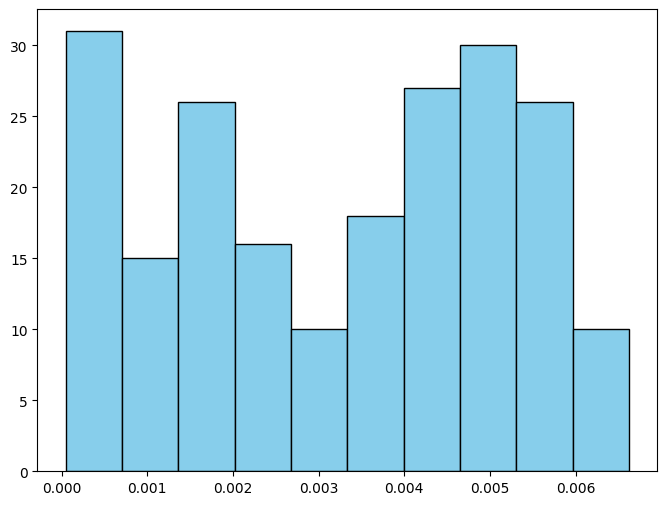

In [33]:
# 히스토그램 그리기
plt.figure(figsize=(8, 6))
plt.hist(coverage, bins=10, color='skyblue', edgecolor='black')

In [141]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [142]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.84688995215311

##### 2. Word2Vec

In [37]:
recommended_items = []

for i in range(0, 209):
    test = recommend_similar_items(i, item_embeddings)
    recommended_items.extend(str(test[0]))


recommended_items = list(map(lambda x: int(x), recommended_items))

In [38]:
from metrics.coverage import get_coverage

n_items = len(item_embeddings)

get_coverage(recommended_items, n_items)

0.04784688995215311

#### INFERENCE

##### 1. CountVec + TF-IDF

In [143]:
content_recommender(100, 10, sold_out)

[array([126,  57, 112,  84,  53, 188,  61, 120,  54,  99], dtype=int64),
 array([1.29851338, 1.12695693, 1.0036207 , 0.91936164, 0.91056195,
        0.87368295, 0.87368295, 0.87368295, 0.87078122, 0.8558868 ])]

##### 2. Word2Vec

In [ ]:
recommend_similar_items(3, item_embeddings)

[110, 145, 142]

#### SAVE

In [41]:
import pandas as pd
from datetime import datetime

In [144]:

query_item = df.index.values.repeat(3)

recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))


score = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    score.extend(test[1])


score = list(map(lambda x: float(x), score))


rank = [1, 2, 3]*cosine_sim.shape[0]

recommendation_theme = ['similarity']*cosine_sim.shape[0]*3

model_version = ['bow-1+TF-IDF']*cosine_sim.shape[0]*3

created_at = [datetime.now()]*cosine_sim.shape[0]*3

modified_at = [datetime.now()]*cosine_sim.shape[0]*3

#### 추천 결과 테이블 포맷
- query item은 찜이 눌린 아이템입니다.
- recommendation item은 query 아이템 당 3개를 추출합니다.
- 유사한 recommendation item이 없을 경우 랜덤한 3개의 결과를 추천합니다.
- 포맷에 맞게 데이터프레임을 만듭니다. 

In [145]:
import pandas as pd
from datetime import datetime
data = {
    'query_item': query_item,
    'recommendation_item': recommended_items,
    'score': score,
    'rank': rank,
    'recommendation_theme': recommendation_theme,
    'model_version': model_version,
    'created_at': created_at,
    'modified_at': modified_at
}

recommendation_df = pd.DataFrame(data)


In [146]:
recommendation_df

,query_item,recommendation_item,score,rank,recommendation_theme,model_version,created_at,modified_at
0,0,23,0.866149,1,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
1,0,90,0.816497,2,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
2,0,177,0.774597,3,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
3,1,29,1.163784,1,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
4,1,17,1.113105,2,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
...,...,...,...,...,...,...,...,...
622,207,61,0.846000,2,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
623,207,120,0.846000,3,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
624,208,110,0.980726,1,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
625,208,175,0.551414,2,similarity,bow-1+TF-IDF,2024-10-31 19:33:16.619417,2024-10-31 19:33:16.619417
